In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 0
setup_one_gpu(GPU)

Picking GPU 0


In [2]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from general_tools.notebook.tf import reset_tf_graph
from general_tools.in_out.basics import create_dir, files_in_subdirs

from geo_tool import Point_Cloud

from tf_lab.in_out.basics import Data_Splitter, read_saved_epochs
from tf_lab.point_clouds.ae_templates import mlp_architecture_ala_iclr_18, default_train_params

from tf_lab.point_clouds.autoencoder import Configuration as Conf
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder

from tf_lab.point_clouds.in_out import load_point_clouds_from_filenames, PointCloudDataSet
from tf_lab.data_sets.shape_net import pc_loader as snc_loader
from tf_lab.data_sets.shape_net import snc_category_to_synth_id

from tf_lab.point_clouds.latent_gan import LatentGAN
from tf_lab.point_clouds.generators_discriminators import latent_code_discriminator_two_layers, \
latent_code_generator_two_layers, latent_code_discriminator, latent_code_generator

from tf_lab.iclr.helper import load_multiple_version_of_pcs, find_best_validation_epoch_from_train_stats
from tf_lab.point_clouds.convenience import get_latent_codes
from tf_lab.neural_net import MODEL_SAVER_ID

from tf_lab.point_clouds.raw_gan_gp import RawGAN_GP
from tf_lab.point_clouds.generators_discriminators import latent_code_generator

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
n_pc_points = 2048
random_seed = 42
do_training = True
plot_train_curve = True 
save_synthetic_samples = True
save_model = False
saver_step = np.hstack([np.array([1, 5, 10]), np.arange(200, 2001, 200)])
ae_loss = 'emd'
do_wgan = True
class_name = 'achlioptas_5_snc'
b_neck = int(raw_input('Give me bneck_size.\n'))
ae_tag = 'mlp_with_split_1pc_usampled'

Give me bneck_size.
128


In [6]:
if do_wgan:
    gan_tag = 'l_w_gan'
else:
    gan_tag = 'l_gan'

experiment_tag = '_'.join([gan_tag, class_name, ae_tag, ae_loss, 'bneck', str(b_neck)])
print experiment_tag

l_w_gan_achlioptas_5_snc_mlp_with_split_1pc_usampled_emd_bneck_128


In [7]:
top_data_dir = '/orions4-zfs/projects/optas/DATA/'
top_pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_points))
train_split = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Splits/achlioptas_snc_5_medium_size_splits/train.txt')
val_split = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Splits/achlioptas_snc_5_medium_size_splits/val.txt')
splitter = Data_Splitter(top_pclouds_path, data_file_ending='.ply', random_seed=random_seed)
tr_files = splitter.load_splits(train_split)
pclouds, model_ids, syn_ids = load_point_clouds_from_filenames(tr_files, n_threads=20, loader=snc_loader, verbose=True)
train_data = PointCloudDataSet(pclouds, labels=syn_ids + '_' + model_ids)
val_files = splitter.load_splits(val_split)
pclouds, model_ids, syn_ids = load_point_clouds_from_filenames(val_files, n_threads=20, loader=snc_loader, verbose=True)
val_data = PointCloudDataSet(pclouds, labels=syn_ids + '_' + model_ids)

/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/tf_lab/point_clouds/in_out.py:38: UserWarning: Point clouds with the same model name were loaded.
  warnings.warn('Point clouds with the same model name were loaded.')


10000 pclouds were loaded. They belong in 5 shape-classes.
500 pclouds were loaded. They belong in 5 shape-classes.


In [8]:
top_lin_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
synthetic_data_out_dir = osp.join(top_lin_dir, 'OUT/iclr/synthetic_samples/', experiment_tag)
create_dir(synthetic_data_out_dir)
train_dir = osp.join(top_lin_dir, 'OUT/iclr/nn_models', experiment_tag)
create_dir(train_dir)

'/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/iclr/nn_models/l_w_gan_achlioptas_5_snc_mlp_with_split_1pc_usampled_emd_bneck_128'

In [9]:
# Load Auto-Encoder
ae_id = '_'.join(['ae_mlp_on_achlioptas_5_snc_2048_pts', str(b_neck), 'bneck', ae_loss])
ae_train_dir = osp.join(top_data_dir, 'OUT/iclr/nn_models/', ae_id)
ae_conf = Conf.load(osp.join(ae_train_dir, 'configuration'))
saved_epochs = read_saved_epochs(ae_conf.train_dir)
_, best_epoch = find_best_validation_epoch_from_train_stats(osp.join(ae_train_dir, 'train_stats.txt'))
if best_epoch % ae_conf.saver_step != 0: # Model was not saved at that epoch.
    best_epoch += best_epoch % ae_conf.saver_step
ae_conf.encoder_args['verbose'] = False
ae_conf.decoder_args['verbose'] = False
reset_tf_graph()
ae = PointNetAutoEncoder(ae_conf.experiment_name, ae_conf)    
ae.restore_model(ae_conf.train_dir, best_epoch, verbose=True)

Model restored in epoch 820.


In [10]:
# Convert raw-data to latent codes.
latent_codes = get_latent_codes(ae, train_data.point_clouds)
train_data = PointCloudDataSet(latent_codes)

In [11]:
init_lr = 0.0001
batch_size = 50
noise_params = {'mu':0, 'sigma': 0.2}
noise_dim = b_neck
max_epochs = 2000
n_syn_samples = train_data.num_examples
n_out = [b_neck]
accum_syn_data = []
train_stats = []

In [12]:
reset_tf_graph()

if do_wgan:
    lam = 10
    beta = 0.5
    reset_tf_graph()
    gan = RawGAN_GP(experiment_tag, init_lr, lam, n_out, noise_dim, \
                    latent_code_discriminator_two_layers, latent_code_generator_two_layers,\
                    beta=beta                    
                   )    
else:
    beta = 0.0
    gan = LatentGAN(experiment_tag, init_lr, n_out, noise_dim, latent_code_discriminator_two_layers,
                    latent_code_generator_two_layers, beta=beta, gen_kwargs={'b_norm': False}, 
                    disc_kwargs={'b_norm': False})

1 (-0.46302597835659981, -0.18796274540945887)


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


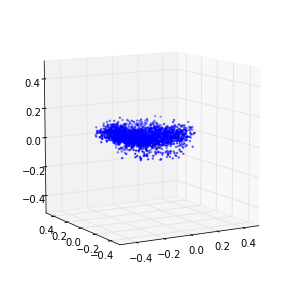

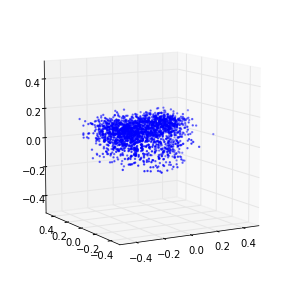

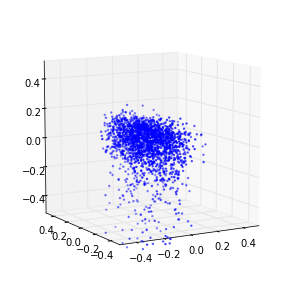

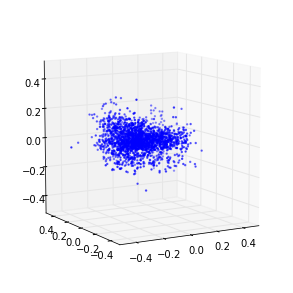

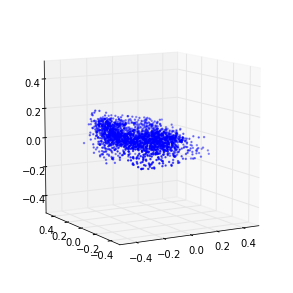

2 (-0.84321271628141403, -0.37362518832087516)
3 (-0.76747330486774445, -0.31754056513309481)
4 (-0.74407605826854706, -0.14763215817511083)
5 (-0.75696690887212759, -0.033397751481970772)


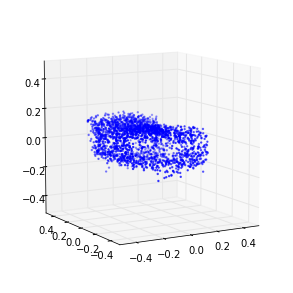

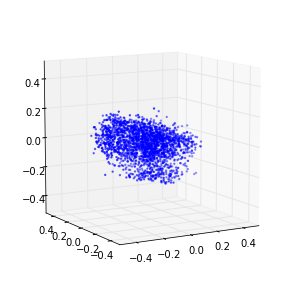

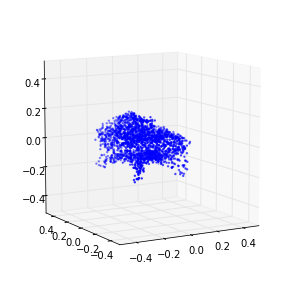

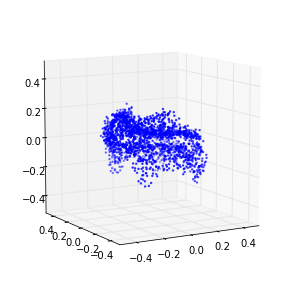

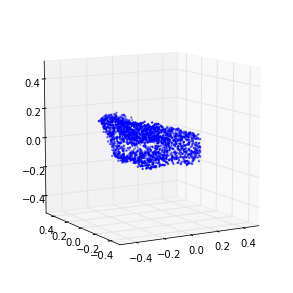

6 (-0.76701779782772062, 0.0083370393345830966)
7 (-0.76982960343360896, 0.0057242467068135735)
8 (-0.76466198414564135, 0.0077451284741982818)
9 (-0.75313946425914768, -0.00075445599504746501)
10 (-0.74017294883728024, -0.012322657299228013)


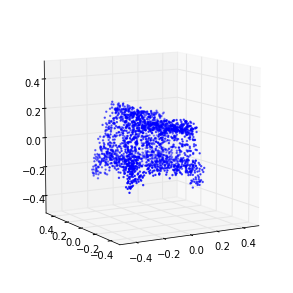

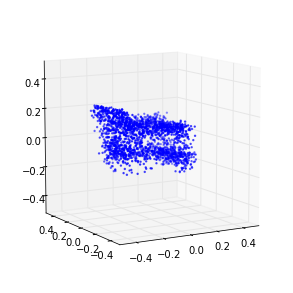

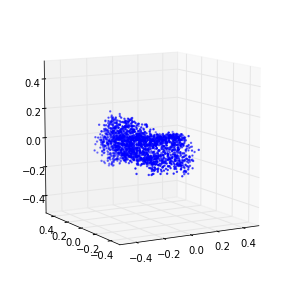

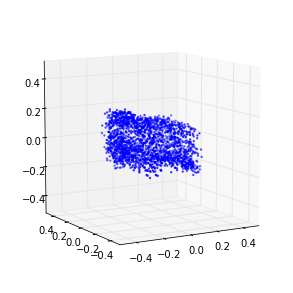

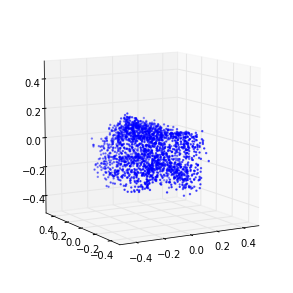

11 (-0.72222201675176623, -0.022944791981717571)
12 (-0.70280633807182313, -0.034707667469047007)
13 (-0.68401411086320874, -0.045773333881516012)
14 (-0.66078041821718214, -0.065629845298826692)
15 (-0.63677190929651262, -0.08080063564702869)
16 (-0.61029737472534185, -0.076394680095836526)
17 (-0.58543478041887287, -0.070150764146819714)
18 (-0.56222012072801586, -0.098392454255372283)
19 (-0.53680379346013074, -0.092838897835463285)
20 (-0.51652862653136256, -0.095890439581125975)
21 (-0.49629055395722388, -0.099938201159238821)
22 (-0.48108817294239997, -0.087352684419602158)
23 (-0.46464244306087493, -0.085263561410829428)
24 (-0.45368308261036872, -0.067851696815341714)
25 (-0.44091832131147385, -0.07107615219429135)
26 (-0.43183263540267947, -0.064526285231113437)
27 (-0.42464881420135497, -0.052123637474142018)
28 (-0.418689151853323, -0.068637258035596463)
29 (-0.40968976303935051, -0.062040498969145118)
30 (-0.40556408926844595, -0.061017991381231693)
31 (-0.40369123652577399

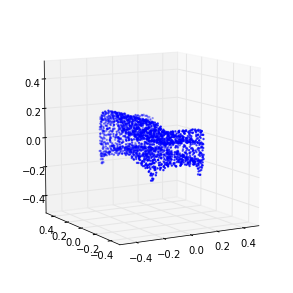

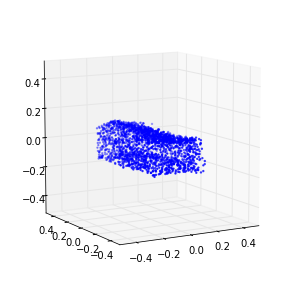

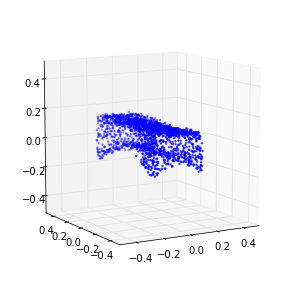

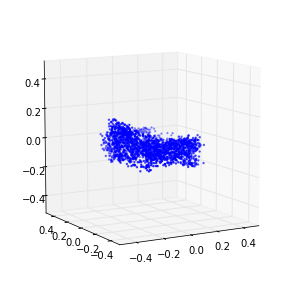

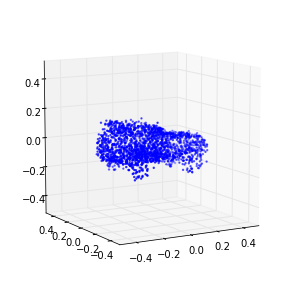

201 (-0.28193790502846239, -0.10957755018025636)
202 (-0.28361753456294536, -0.10878536328673363)
203 (-0.28116915583610536, -0.10157218175008893)
204 (-0.28039930790662765, -0.11291686166077852)
205 (-0.2840956602245569, -0.11169195361435413)
206 (-0.28066569671034813, -0.098887539096176619)
207 (-0.28235280789434908, -0.10445035826414824)
208 (-0.2813551642745733, -0.11074264915660023)
209 (-0.28268402360379696, -0.11354677956551314)
210 (-0.27919980585575105, -0.1172097286209464)
211 (-0.27860829070210458, -0.11354498546570539)
212 (-0.28127450361847878, -0.11579164415597916)
213 (-0.28071269012987615, -0.10725986026227474)
214 (-0.28127959832549093, -0.11374772042036056)
215 (-0.28000207088887691, -0.11955194305628539)
216 (-0.28318682707846166, -0.12062758542597293)
217 (-0.27997353099286554, -0.1163440490141511)
218 (-0.28050288647413252, -0.12083012778311968)
219 (-0.27965705521404743, -0.11617145631462336)
220 (-0.27811958223581312, -0.11877830717712641)
221 (-0.279685504734516

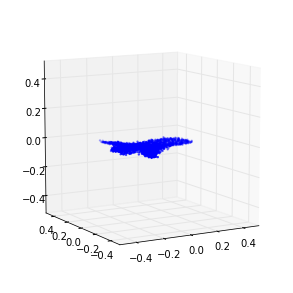

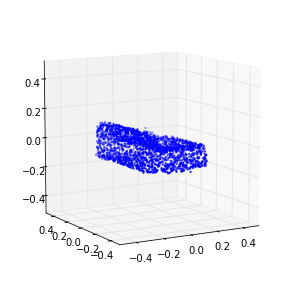

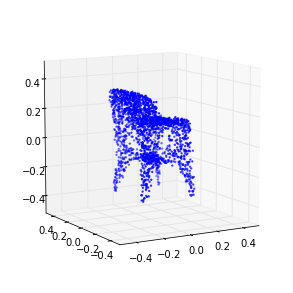

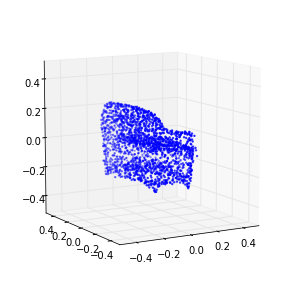

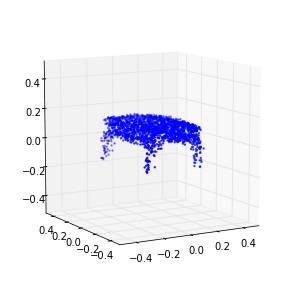

401 (-0.24756325639784335, -0.046585989184677601)
402 (-0.2501740677654743, -0.043016850575804712)
403 (-0.24462975710630416, -0.048918421007692815)
404 (-0.24567706450819971, -0.042256368469679728)
405 (-0.24912826284766199, -0.038246176182292403)
406 (-0.24684690400958062, -0.044906510505825281)
407 (-0.24608603984117508, -0.039836039161309601)
408 (-0.2469098850339651, -0.037803471088409424)
409 (-0.24508631974458694, -0.04180971831083298)
410 (-0.24357116691768169, -0.037723569828085599)
411 (-0.24384301893413066, -0.039463891787454485)
412 (-0.24420231692492961, -0.043245345866307613)
413 (-0.24373531758785247, -0.036915189190767708)
414 (-0.24407829403877257, -0.03536405302584171)
415 (-0.24338708721101285, -0.041352578881196679)
416 (-0.24341796897351742, -0.035211464663734662)
417 (-0.24183649010956287, -0.042354710574727505)
418 (-0.24318712122738362, -0.040278336178744212)
419 (-0.2441731409728527, -0.045798549277242272)
420 (-0.24321855962276459, -0.034303736616857351)
421 (

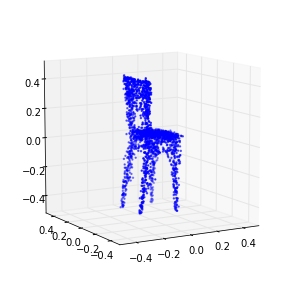

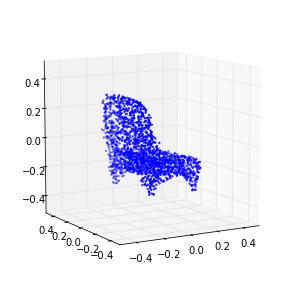

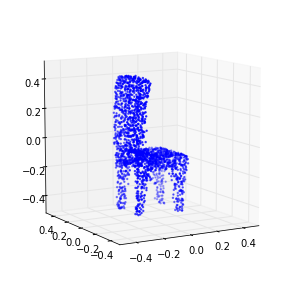

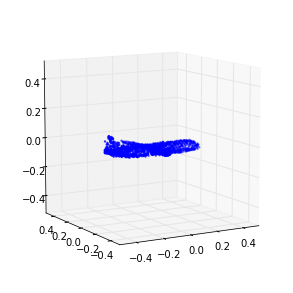

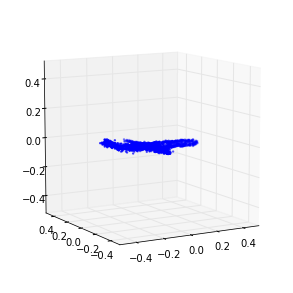

601 (-0.20198020212352275, 0.046325438906205815)
602 (-0.2025781463086605, 0.056816926365718244)
603 (-0.2007794239372015, 0.052437630342319609)
604 (-0.20051199227571487, 0.055526030622422694)
605 (-0.201225531026721, 0.055923186754807827)
606 (-0.20059080265462398, 0.059784712502732873)
607 (-0.20099652044475078, 0.060681256931275129)
608 (-0.20047385878860952, 0.061271681031212208)
609 (-0.20034496117383241, 0.063102253619581467)
610 (-0.19881556026637554, 0.060201893094927073)
611 (-0.1999344277381897, 0.063829315826296806)
612 (-0.20046541675925256, 0.059721557423472404)
613 (-0.20033822171390056, 0.051580097025725989)
614 (-0.2011254420131445, 0.052686137426644561)
615 (-0.20064399354159831, 0.061059963269508445)
616 (-0.20156053982675076, 0.05629091113805771)
617 (-0.19716794669628143, 0.052046512695960702)
618 (-0.20004969611763954, 0.056143451994284985)
619 (-0.19602544769644736, 0.05898433830589056)
620 (-0.1994229294359684, 0.057857100339606407)
621 (-0.19905995436012744, 0.

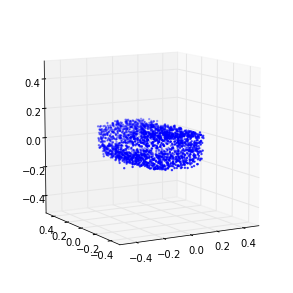

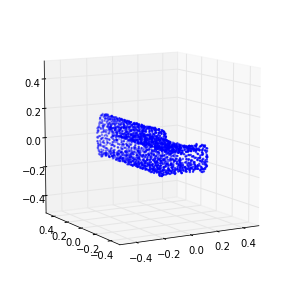

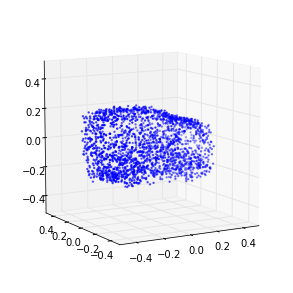

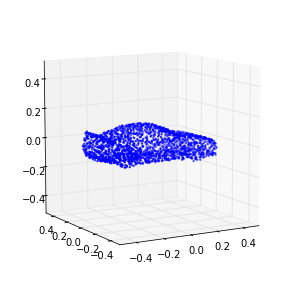

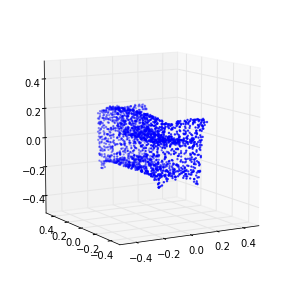

801 (-0.18000499203801154, 0.15044157356023788)
802 (-0.18100663479417561, 0.13200361039489508)
803 (-0.18118838138878346, 0.12919834982603789)
804 (-0.18183183711022138, 0.13757908251136541)
805 (-0.18298261556774378, 0.13544960767030717)
806 (-0.18134029518812894, 0.1378869317471981)
807 (-0.17946194589138031, 0.13336108289659024)
808 (-0.18087993729859592, 0.13627437707036733)
809 (-0.18158057957887649, 0.13975151889026166)
810 (-0.17862993285059928, 0.14266688376665115)
811 (-0.17983171593397856, 0.14423039387911557)
812 (-0.18044579464942218, 0.14079254418611525)
813 (-0.17918795436620713, 0.15036435164511203)
814 (-0.18190291605889797, 0.14121945351362228)
815 (-0.17913820207118988, 0.14316283427178861)
816 (-0.18024891637265683, 0.13776491135358809)
817 (-0.17829040579497815, 0.14347288347780704)
818 (-0.17979944668710232, 0.14948175549507142)
819 (-0.18133998185396194, 0.14234577789902686)
820 (-0.17999827772378921, 0.15159029550850392)
821 (-0.17831679552793503, 0.145877059362

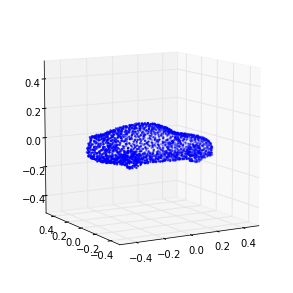

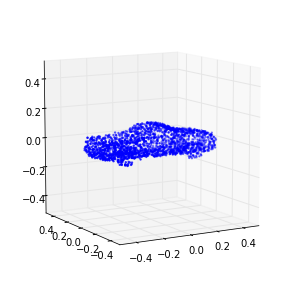

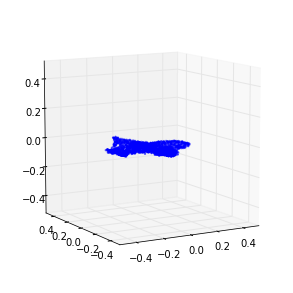

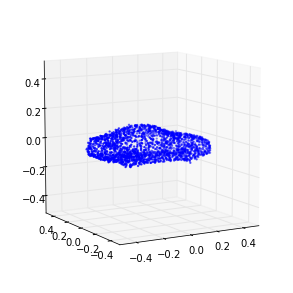

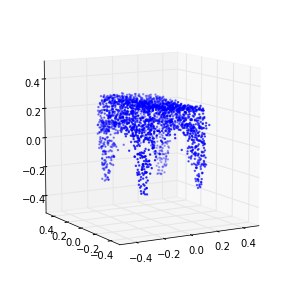

1001 (-0.16859806168824434, 0.2062040340155363)
1002 (-0.17192139036953449, 0.20161106437444687)
1003 (-0.17034454025328161, 0.20802972018718718)
1004 (-0.169558022916317, 0.21032048985362053)
1005 (-0.17228666506707668, 0.21105322130024434)
1006 (-0.17073993731290102, 0.20294626615941525)
1007 (-0.16853749293833972, 0.21083202697336673)
1008 (-0.1688196225836873, 0.20922668762505053)
1009 (-0.16998398512601853, 0.20986597500741483)
1010 (-0.16829331066459419, 0.20910990573465824)
1011 (-0.16764286942780018, 0.21178378872573375)
1012 (-0.1690726289898157, 0.20683220028877258)
1013 (-0.16696989834308623, 0.20319661162793637)
1014 (-0.16872593116015197, 0.20991307199001313)
1015 (-0.17029971364885568, 0.20786036401987076)
1016 (-0.16980417691171168, 0.21592673026025294)
1017 (-0.16691543471068143, 0.21404255852103232)
1018 (-0.16831477932631969, 0.20589375011622907)
1019 (-0.16913166508078575, 0.2129556480795145)
1020 (-0.16941014561802148, 0.21809778288006781)
1021 (-0.16921448215842247

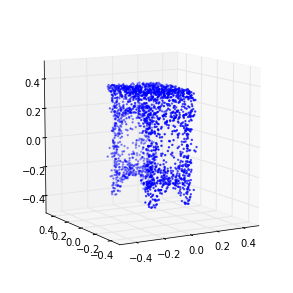

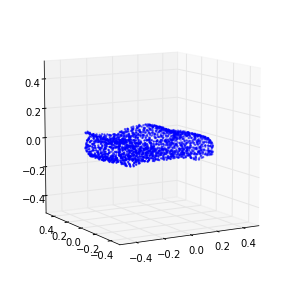

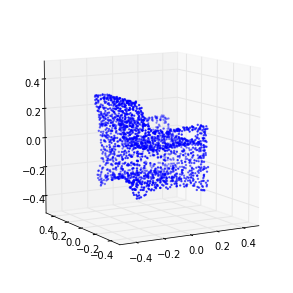

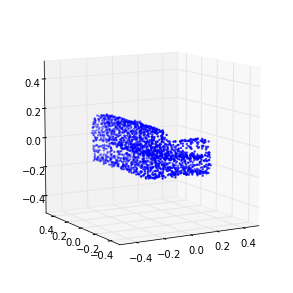

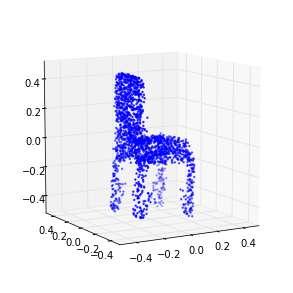

1201 (-0.15854633133858442, 0.21604408323764801)
1202 (-0.16243076950311661, 0.21011241562664509)
1203 (-0.16154694341123105, 0.20577015802264215)
1204 (-0.16129206519573927, 0.21042842604219913)
1205 (-0.16012986443936825, 0.21082318536937236)
1206 (-0.16129706986248493, 0.21840443462133408)
1207 (-0.16061138190329075, 0.21159050203859806)
1208 (-0.162122066244483, 0.2215656816959381)
1209 (-0.15895253982394933, 0.20271589010953903)
1210 (-0.15990253128111362, 0.21410570144653321)
1211 (-0.16039114613085986, 0.20297856256365776)
1212 (-0.15763283532112837, 0.21135264858603478)
1213 (-0.15979547642171382, 0.21785062588751317)
1214 (-0.16112961798906325, 0.2047164723277092)
1215 (-0.16071677535772325, 0.21338904462754726)
1216 (-0.16103956144303083, 0.20867239125072956)
1217 (-0.15989541936665774, 0.21030441559851171)
1218 (-0.16151878427714109, 0.21250130645930768)
1219 (-0.16097570203244685, 0.21126387566328048)
1220 (-0.16032291326671838, 0.20754091665148736)
1221 (-0.159010277763009

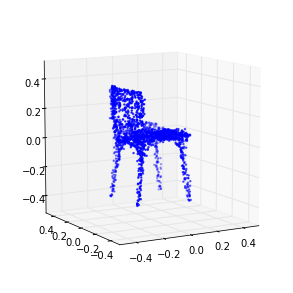

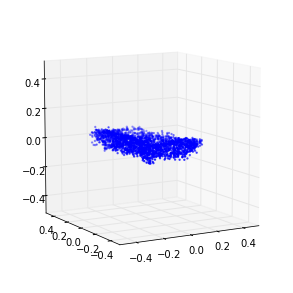

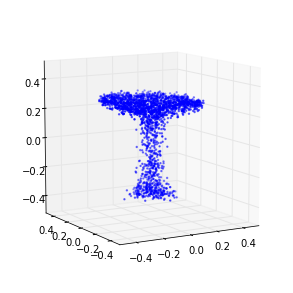

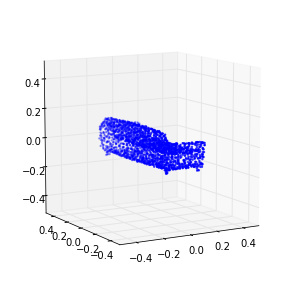

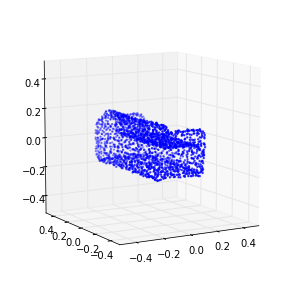

1401 (-0.15380186259746551, 0.20131403058767319)
1402 (-0.15643578287214041, 0.20165856592357159)
1403 (-0.15527781315147876, 0.2015657603740692)
1404 (-0.15607096310704946, 0.2028444480150938)
1405 (-0.15473056539893151, 0.19862814247608185)
1406 (-0.15642856527119875, 0.20908154174685478)
1407 (-0.15485456187278032, 0.20726134963333606)
1408 (-0.15608409874141216, 0.19398797079920768)
1409 (-0.1541827940940857, 0.19991851449012757)
1410 (-0.15572040647268295, 0.20125020891427994)
1411 (-0.15586043849587441, 0.19898370616137981)
1412 (-0.15452630367130041, 0.20207751914858818)
1413 (-0.15522461384534836, 0.19619123674929143)
1414 (-0.15677918490022422, 0.20729468390345573)
1415 (-0.15318752530962229, 0.20026032663881779)
1416 (-0.1565975783392787, 0.20393254719674586)
1417 (-0.1542094299197197, 0.19234192781150342)
1418 (-0.15366695646196604, 0.1976017165929079)
1419 (-0.15424551032483577, 0.19599343091249466)
1420 (-0.15334199145436286, 0.19505693912506103)
1421 (-0.15700708918273448

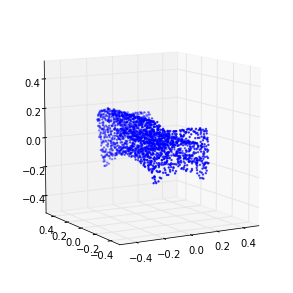

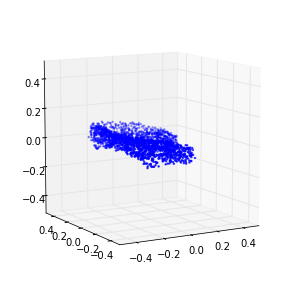

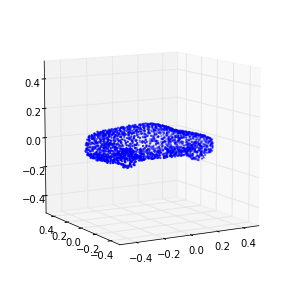

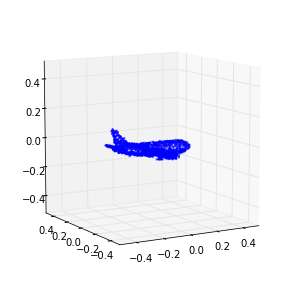

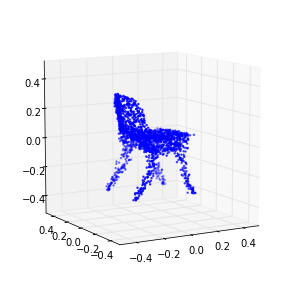

1601 (-0.15003805354237557, 0.17120285667479038)
1602 (-0.1473212493211031, 0.17913070432841777)
1603 (-0.15019104249775408, 0.17248987555503845)
1604 (-0.14984358597546815, 0.17271272689104081)
1605 (-0.15128636065870524, 0.18360958807170391)
1606 (-0.15192887056618928, 0.18042130134999751)
1607 (-0.15092774726450442, 0.17938440404832362)
1608 (-0.15131778243929148, 0.18276700302958487)
1609 (-0.14995399270206689, 0.17791803516447544)
1610 (-0.15123569399118422, 0.1732181716710329)
1611 (-0.15098399098962545, 0.18095638826489449)
1612 (-0.14918821301311255, 0.17829585410654544)
1613 (-0.14998688008636235, 0.17398704104125501)
1614 (-0.15084980022162198, 0.17934212535619737)
1615 (-0.15126806933432818, 0.17859916910529136)
1616 (-0.14883744198828935, 0.18056866079568862)
1617 (-0.14992706187069416, 0.17471611015498639)
1618 (-0.1519220307469368, 0.1828600775450468)
1619 (-0.15057074751704932, 0.17362768314778804)
1620 (-0.14938429336994885, 0.18105410225689411)
1621 (-0.149108039662241

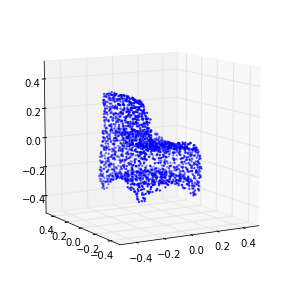

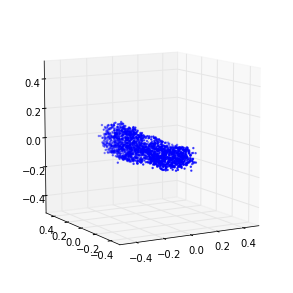

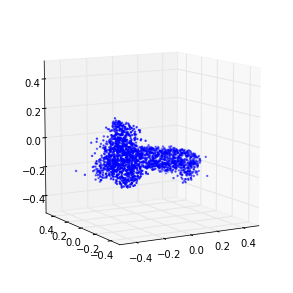

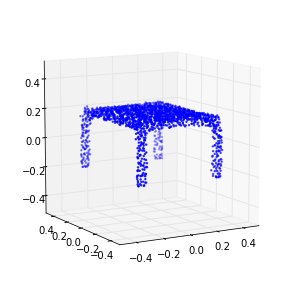

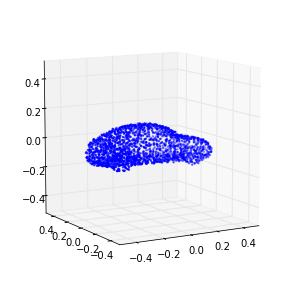

1801 (-0.14780306164175272, 0.17685856819152831)
1802 (-0.14641505211591721, 0.17732931971549987)
1803 (-0.14783727694302798, 0.18317619077861308)
1804 (-0.14829395137727261, 0.1843555487692356)
1805 (-0.14853987958282233, 0.18405639380216599)
1806 (-0.14662252184003591, 0.18902069851756095)
1807 (-0.14624850880354642, 0.18096617795526981)
1808 (-0.14473554875701666, 0.18355833180248737)
1809 (-0.14673544932156801, 0.18799272775650025)
1810 (-0.14763038601726294, 0.18282263204455376)
1811 (-0.14731323443353175, 0.18750509768724441)
1812 (-0.14724006582051516, 0.18353520035743714)
1813 (-0.14693701751530169, 0.18389488905668258)
1814 (-0.14658627953380346, 0.18821563608944417)
1815 (-0.14745370339602232, 0.18071745447814463)
1816 (-0.148539218865335, 0.18775320723652839)
1817 (-0.14546920437365771, 0.18552062697708607)
1818 (-0.14814639292657375, 0.19201875180006028)
1819 (-0.1459979546442628, 0.18323341906070709)
1820 (-0.14628376848995686, 0.18510508090257644)
1821 (-0.145504300408065

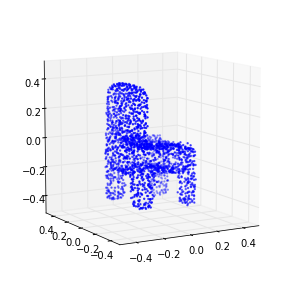

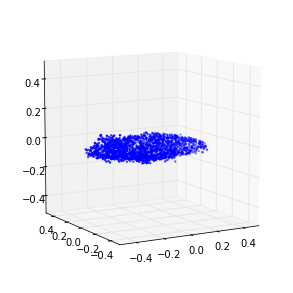

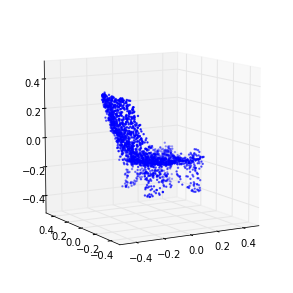

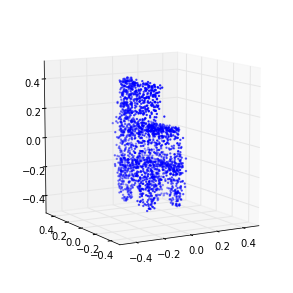

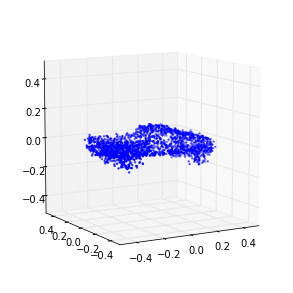

In [13]:
if do_training:
    for _ in range(max_epochs):
        loss, duration = gan._single_epoch_train(train_data, batch_size, noise_params)
        epoch = int(gan.sess.run(gan.epoch.assign_add(tf.constant(1.0))))
        print epoch, loss
        
        if save_model and (epoch % saver_step == 0 or epoch <= 5):
            checkpoint_path = osp.join(train_dir, MODEL_SAVER_ID)
            gan.saver.save(gan.sess, checkpoint_path, global_step=gan.epoch)
        
        if save_synthetic_samples and epoch in saver_step:
            syn_latent_data = gan.generate(n_syn_samples, noise_params)
            syn_data = ae.decode(syn_latent_data)
            np.savez(osp.join(synthetic_data_out_dir, 'epoch_' + str(epoch)), syn_data)
            for k in range(5):
                Point_Cloud(syn_data[k]).plot()
            
        train_stats.append((epoch,) + loss)


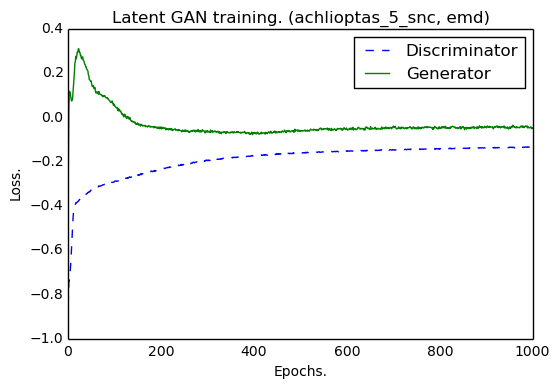

In [25]:
if plot_train_curve:
    x = range(len(train_stats))
    d_loss = [t[1] for t in train_stats]
    g_loss = [t[2] for t in train_stats]
    plt.plot(x, d_loss, '--')
    plt.plot(x, g_loss)
    plt.title('Latent GAN training. (%s, %s)' %(class_name, ae_loss))
    plt.legend(['Discriminator', 'Generator'], loc=0)
    
    plt.tick_params(axis='x', which='both', bottom='off', top='off')
    plt.tick_params(axis='y', which='both', left='off', right='off')
    
    plt.xlabel('Epochs.') 
    plt.ylabel('Loss.')